<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [312]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
from scipy import stats

In [204]:
seaborn.__version__

'0.10.1'

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [205]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [206]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [207]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
    'ef_money_inflation'
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [208]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [209]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
  dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0,9.6
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0,8.9
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0,3.7
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0,4.9
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0,9.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0,9.1
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0,9.3
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0,9.5
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0,9.2


### Dataset Latin America & the Caribbean

In [214]:
dataset_la = dataset[dataset.region == 'Latin America & the Caribbean']
dataset_la.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0,4.9
8,2017,BHS,Bahamas,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,7.87,48.0,7.25,58.0,7.56,48.0,9.7
11,2017,BRD,Barbados,Latin America & the Caribbean,NaN,0.0,0.0,0.0,10.0,5.0,7.59,57.0,6.45,112.0,7.02,66.0,9.1
14,2017,BLZ,Belize,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,7.12,74.0,6.78,85.0,6.95,68.0,9.8
17,2017,BOL,Bolivia,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,7.07,75.0,6.14,126.0,6.61,97.0,9.4


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  2. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 

    Resp: Proponemos compararlos teniendo en cuenta todos los valores para cada variable (10) y graficarlos para poder hacer una comparacion año tras año.
En el caso de comparar regiones, utilizo la mediana, ya que de esta forma no influyen los paises con HF extremos (por ejemplo el caso de Venezuela que esta muy por debajo de la media de Latino America.)

  3. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  
    Al comparar con un unico valor (media o mediana) y no año tras año, perdemos la evolución de las variables. 
  
  4. ¿Tiene sentido calcular la moda?

    Resp: NO, porque tenemos pocos datos para cada variable, y cada variable es numerica, lo que nos da un rango muy amplio de posibles valores.
    
    Son variables numericas continuas, no tiene sentido calcular la Moda.  

  5. ¿Cómo pueden sanearse los valores faltantes?
  6. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
   
  
  

## Rango de Variables

## Calculamos rango de variables para Latinoamerica y para todo el Mundo.


### Latin America & the Caribbean

In [215]:
dataset_la.describe().reset_index()

,index,year,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
0,count,260.000000,60.000000,258.000000,258.000000,258.000000,248.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
1,mean,2012.500000,3.966667,8.023256,9.224806,8.624031,9.455645,8.582171,7.348333,70.546512,6.725271,79.170543,7.036977,71.918605,8.570930
2,std,2.877821,4.786870,3.990192,2.679335,2.982785,1.494270,1.875832,0.633831,21.876016,0.896733,35.990298,0.634897,25.144817,1.809048
3,min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000,5.030000,27.000000,2.580000,10.000000,3.800000,25.000000,0.000000
4,25%,2010.000000,0.000000,10.000000,10.000000,10.000000,10.000000,6.850000,6.932500,53.250000,6.432500,51.000000,6.762500,55.250000,8.525000
5,50%,2012.500000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,7.290000,71.500000,6.905000,78.000000,7.020000,69.000000,9.100000
6,75%,2015.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,7.770000,85.000000,7.287500,105.500000,7.377500,87.000000,9.500000
7,max,2017.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.820000,149.000000,7.930000,162.000000,8.180000,161.000000,10.000000


### World

In [216]:
dataset.describe().reset_index()

,index,year,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
0,count,1620.000000,308.000000,1537.000000,1540.000000,1540.000000,1519.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1569.000000
1,mean,2012.500000,6.379870,6.701366,7.922078,7.314935,7.485188,7.280649,7.163409,77.671429,6.792981,77.420779,6.978214,77.465584,8.857616
2,std,2.873168,3.640415,4.685828,4.038529,4.056317,3.502156,3.181577,1.392409,44.757695,0.906827,44.776169,1.056239,44.782074,1.415785
3,min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000,1.000000,2.580000,1.000000,3.690000,1.000000,0.000000
4,25%,2010.000000,7.000000,0.000000,10.000000,5.000000,5.000000,5.000000,6.147500,39.000000,6.220000,39.000000,6.280000,39.000000,8.600000
5,50%,2012.500000,7.000000,10.000000,10.000000,10.000000,10.000000,8.800000,7.145000,77.500000,6.880000,77.000000,6.900000,77.000000,9.300000
6,75%,2015.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.380000,116.000000,7.440000,116.000000,7.880000,116.000000,9.700000
7,max,2017.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.560000,162.000000,9.110000,162.000000,9.120000,162.000000,10.000000


### Media, Mediana y Desv Estándar pf_identity y hf_score

#### PF_IDENTITY

In [217]:
print('Median Mundial', dataset.pf_identity.median())
print('Median Latino América', dataset_la.pf_identity.median())
print('\n')
print('Mean Mundial', dataset.pf_identity.mean())
print('Mean Latino América', dataset_la.pf_identity.mean())
print('\n')
print('Std Mundial', dataset.pf_identity.std())
print('Std Latino América', dataset_la.pf_identity.std())

Median Mundial 8.8
Median Latino América 10.0


Mean Mundial 7.280649350649351
Mean Latino América 8.582170542635659


Std Mundial 3.1815770188080887
Std Latino América 1.875832354285877


#### HF_SCORE

In [218]:
print('Median Mundial', dataset.hf_score.median())
print('Median Latino América', dataset_la.hf_score.median())
print('\n')
print('Mean Mundial', dataset.hf_score.mean())
print('Mean Latino América', dataset_la.hf_score.mean())
print('\n')
print('Std Mundial', dataset.hf_score.std())
print('Std Latino América', dataset_la.hf_score.std())

Median Mundial 6.9
Median Latino América 7.02


Mean Mundial 6.978214285714286
Mean Latino América 7.036976744186046


Std Mundial 1.0562392335897268
Std Latino América 0.6348970989895226


## Outliers a nivel Mundial

Grafico de Caja para chequear outliers

Con respecto a la variable HF_SCORE encontramos valores extremos en un grafico de caja provenientes de los paises Venezuela y Syria, pero cuando analizamos sus valores no podemos considerarlos Outliers ya que son valores reales. 



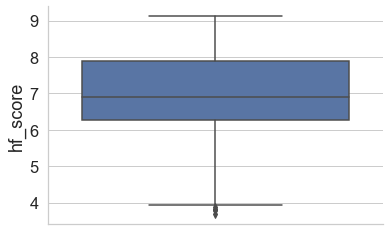

In [219]:
seaborn.boxplot(data=dataset, y='hf_score')
seaborn.despine()

In [220]:
hf_outliers = (dataset.hf_score<4)
dataset[hf_outliers]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
141,2017,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,2.53,162.0,5.05,155.0,3.79,162.0,4.2
157,2017,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,2.5,4.2,5.03,149.0,2.58,162.0,3.80,161.0,0.0
303,2016,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,2.45,161.0,4.93,159.0,3.69,162.0,1.0
465,2015,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,2.79,158.0,4.87,155.0,3.83,159.0,0.0
627,2014,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,3.00,158.0,4.88,155.0,3.94,159.0,1.0
789,2013,SYR,Syria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,3.79,156.0,3.97,156.0,3.88,157.0,0.0


#### Realizamos el mismo análisis para la variable PF_IDENTITY, encontramos algunos paises con valor cero en esta variable, todos pertenecientes a las regiones de South Asis, Sub-Saharan Africa y principalmente en Middle East & Notrh Africa.

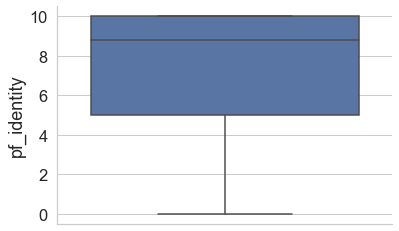

In [221]:
seaborn.boxplot(data=dataset, y='pf_identity')
seaborn.despine()

In [222]:
hf_outliers = (dataset.pf_identity == 0)
dataset[hf_outliers].groupby('region').count()

,year,ISO_code,countries,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
region,,,,,,,,,,,,,,,,
Middle East & North Africa,67,67,67,0,67,67,67,67,67,67,67,67,67,67,67,67
South Asia,19,19,19,0,19,19,19,19,19,19,19,19,19,19,19,19
Sub-Saharan Africa,14,14,14,0,14,14,14,14,14,14,14,14,14,14,14,14


## Outliers Latin America

Para Latino America, nuestro Outlier es Venezuela.

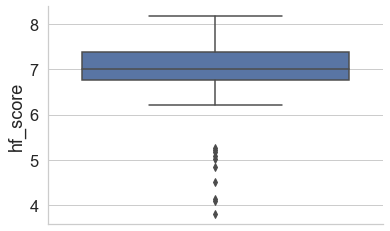

In [223]:
seaborn.boxplot(data=dataset_la, y='hf_score')
seaborn.despine()

In [226]:
dataset_la_outliers = (dataset_la.hf_score < 6)
dataset_la[dataset_la_outliers]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
157,2017,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,2.5,4.2,5.03,149.0,2.58,162.0,3.80,161.0,0.0
319,2016,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,10.0,6.7,5.60,134.0,2.65,162.0,4.13,161.0,0.0
481,2015,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,10.0,6.7,5.44,138.0,2.71,159.0,4.08,158.0,0.0
643,2014,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.03,121.0,2.96,159.0,4.50,158.0,0.0
805,2013,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.67,96.0,3.01,157.0,4.84,154.0,1.9
967,2012,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.63,93.0,3.54,153.0,5.09,147.0,5.8
1129,2011,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.79,92.0,3.64,153.0,5.21,146.0,4.8
1291,2010,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.35,113.0,3.68,153.0,5.02,150.0,4.2
1453,2009,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.24,113.0,4.11,140.0,5.18,139.0,4.3
1484,2008,VEN,Venezuela,Latin America & the Caribbean,NaN,10.0,10.0,10.0,10.0,10.0,6.33,108.0,4.21,140.0,5.27,136.0,3.7


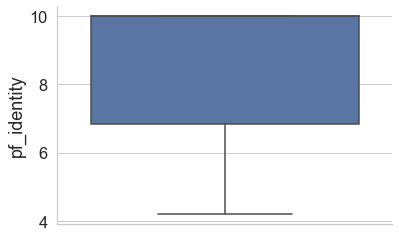

In [227]:
seaborn.boxplot(data=dataset_la, y='pf_identity')
seaborn.despine()

In [228]:
dataset_la_outliers = (dataset_la.pf_identity < 5)
dataset_la[dataset_la_outliers]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,ef_money_inflation
74,2017,JAM,Jamaica,Latin America & the Caribbean,0.0,0.0,10.0,5.0,7.5,4.2,7.23,66.0,7.17,61.0,7.2,59.0,9.1
157,2017,VEN,Venezuela,Latin America & the Caribbean,0.0,10.0,10.0,10.0,2.5,4.2,5.03,149.0,2.58,162.0,3.8,161.0,0.0


## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

        Mediante un relplot de Seaborn podemos ver todos los paises de latinoamerica y sus tendencias, de ahi seleccionamos los convenientes. 

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

In [229]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

# seaborn.set_context(context='talk', font_scale=1.5)
seaborn.set(style='whitegrid', font_scale=1.5)

Text(0.5, 0, 'Years')

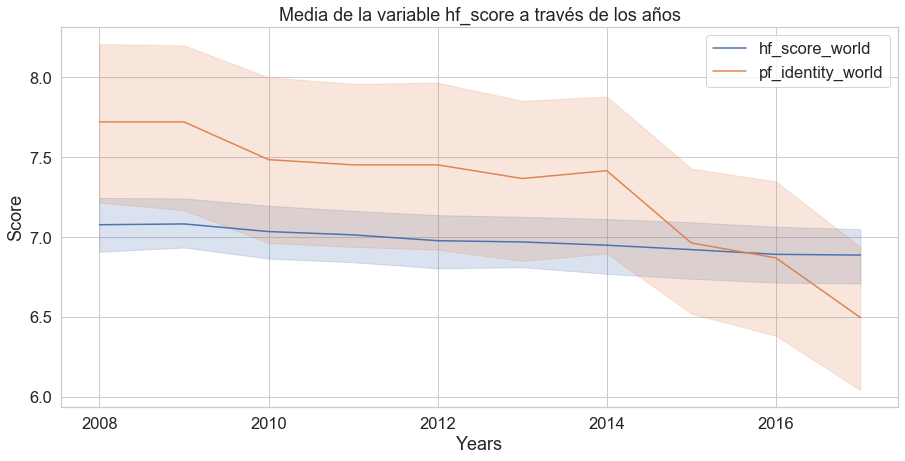

In [230]:
plt.figure(figsize=(15,7))
plt.title('Media de la variable hf_score a través de los años')
# seaborn.lineplot(data=dataset_la, x='year', y='hf_score', label='hf_score_la')
seaborn.lineplot(data=dataset, x='year', y='hf_score', label='hf_score_world')
# seaborn.lineplot(data=dataset_la, x='year', y='pf_identity', label='pf_identity_la')
seaborn.lineplot(data=dataset, x='year', y='pf_identity', label='pf_identity_world')
plt.ylabel('Score')
plt.xlabel('Years')

Comparando estas variables podemos observar que la tendencia en baja de Human Freedom esta siendo afectada por la Identidad. 

Si comparamos el mundo con latinoamerica.

Se aprecia una disminución en la Libertad a nivel mundial que afecta en similares medidas tanto a latinoamerica como al mundo entero. 
Desde el año 2014 se observa una fuerte caida en la identidad, sobretodo en Latino America.

### Comparamos las variables por Regiones

Text(0.5, 0, 'Years')

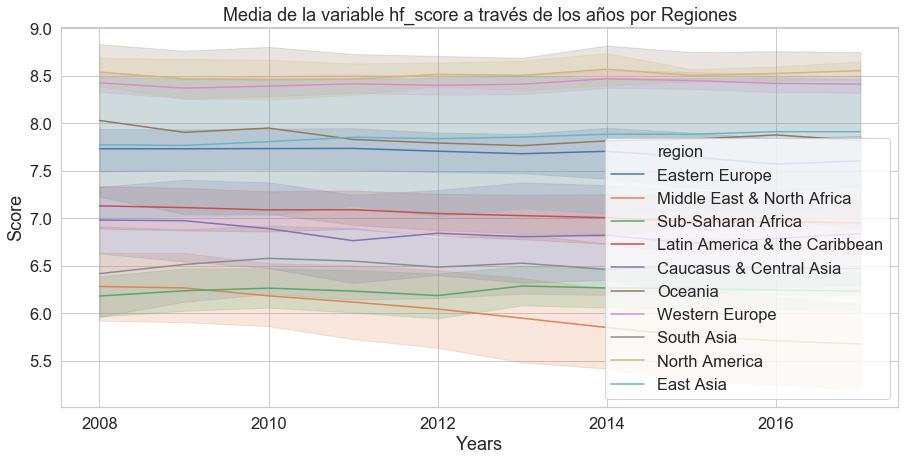

In [231]:
plt.figure(figsize=(15,7))
plt.title('Media de la variable hf_score a través de los años por Regiones')
seaborn.lineplot(data=dataset, x='year', y='hf_score', hue='region')
plt.ylabel('Score')
plt.xlabel('Years')

Text(0.5, 0, 'Years')

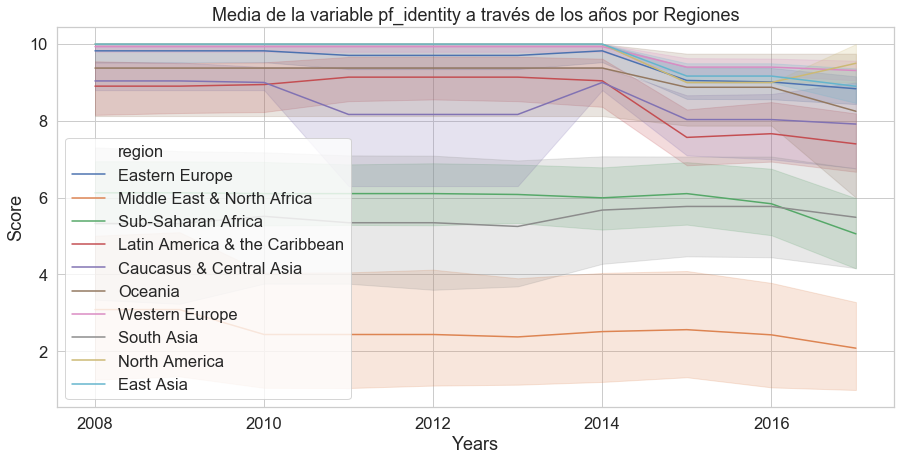

In [232]:
plt.figure(figsize=(15,7))
plt.title('Media de la variable pf_identity a través de los años por Regiones')
seaborn.lineplot(data=dataset, x='year', y='pf_identity', hue='region')
plt.ylabel('Score')
plt.xlabel('Years')

Text(3255.5252499999997, 0.5, 'Score')

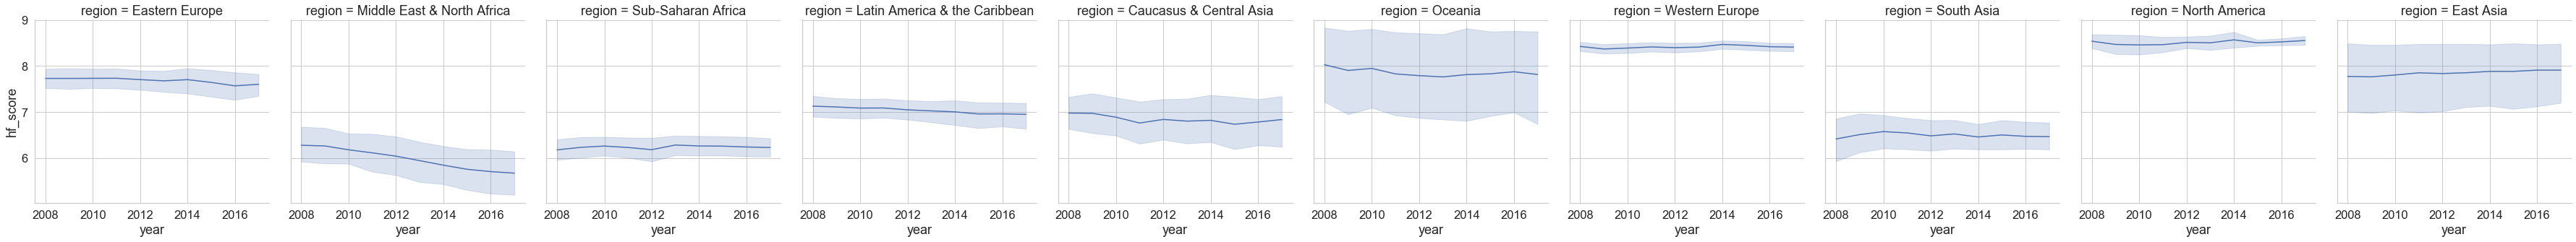

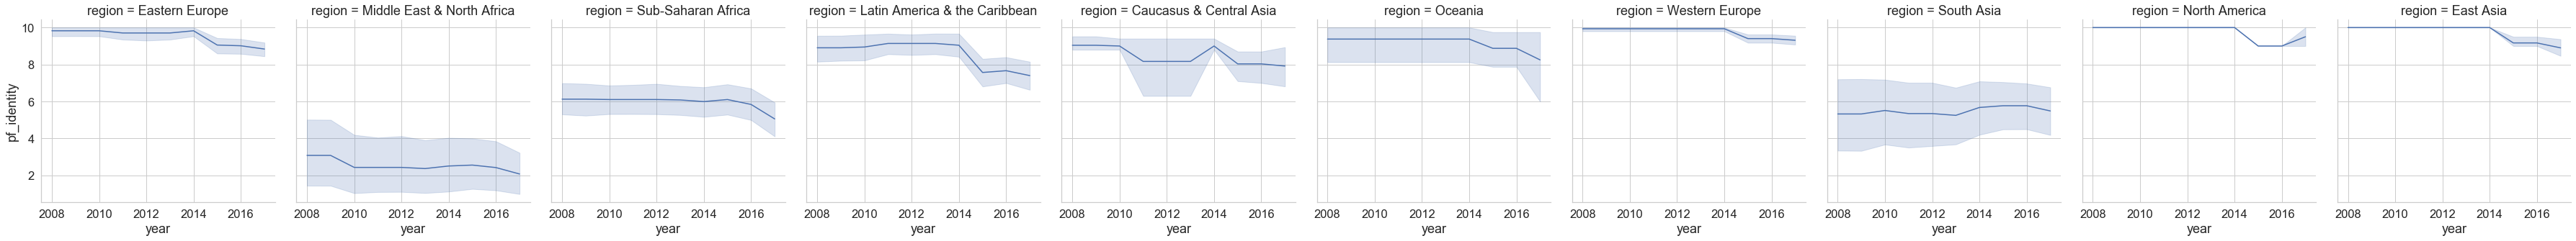

In [233]:
seaborn.relplot(x="year", y="hf_score", col="region", kind="line", data=dataset);
seaborn.relplot(x="year", y="pf_identity", col="region", kind="line", data=dataset);
plt.ylabel('Score')

## Media para pf_identity

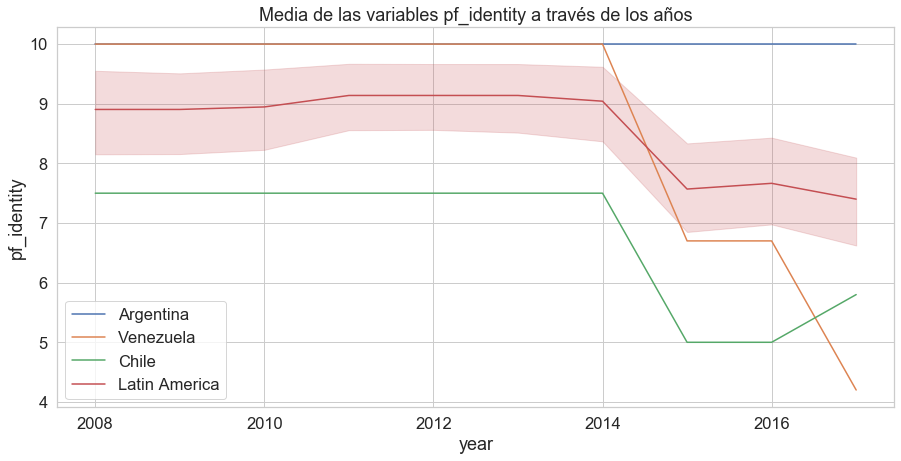

In [234]:
plt.figure(figsize=(15,7))
plt.title('Media de las variables pf_identity a través de los años')
# seaborn.lineplot(data=dataset[dataset.countries == 'Canada'], x='year', y='pf_identity', label='canada')
seaborn.lineplot(data=dataset[dataset.countries == 'Argentina'], x='year', y='pf_identity', label='Argentina')
seaborn.lineplot(data=dataset[dataset.countries == 'Venezuela'], x='year', y='pf_identity', label='Venezuela')
seaborn.lineplot(data=dataset[dataset.countries == 'Chile'], x='year', y='pf_identity', label='Chile')
# seaborn.lineplot(data=dataset_la, x='year', y='pf_identity', hue='countries')
seaborn.lineplot(data=dataset_la, x='year', y='pf_identity', label='Latin America')

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?
  
    pf_identity presenta una distribución sesgada a la derecha.
    
    hf_score es mas parecida a una normal? 


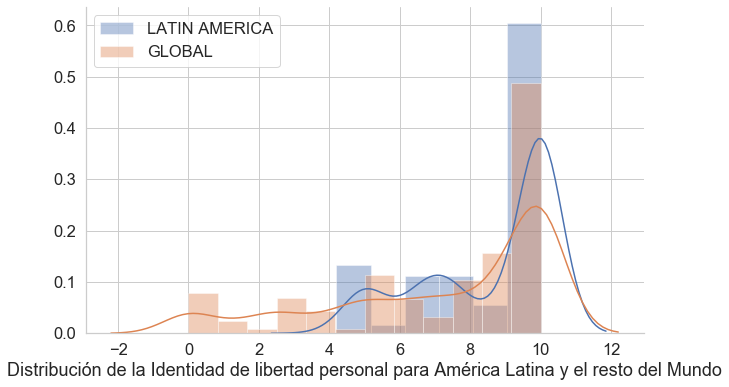

In [235]:
plt.figure(figsize=(10,6))
seaborn.distplot(dataset_la.pf_identity, label='LATIN AMERICA')
seaborn.distplot(dataset.pf_identity, label='GLOBAL')
plt.xlabel('Distribución de la Identidad de libertad personal para América Latina y el resto del Mundo')
plt.legend()
seaborn.despine()

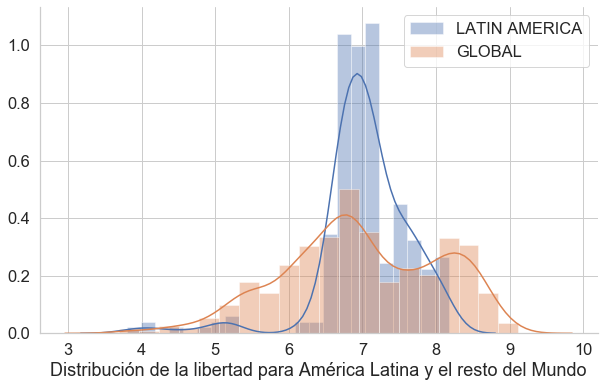

In [236]:
plt.figure(figsize=(10,6))
seaborn.distplot(dataset_la.hf_score, label='LATIN AMERICA')
seaborn.distplot(dataset.hf_score, label='GLOBAL')
plt.xlabel('Distribución de la libertad para América Latina y el resto del Mundo')
plt.legend()
seaborn.despine()

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



### Respuestas

4.1 No me parece adecuado para pf_identity ya que presenta valores discretos.
    Veo una relación entre pf_score y ef_score, a mayor pf_score, mayor ef_score. Excepto algunos puntos de Latin America y Middle East & Notrh Africa.

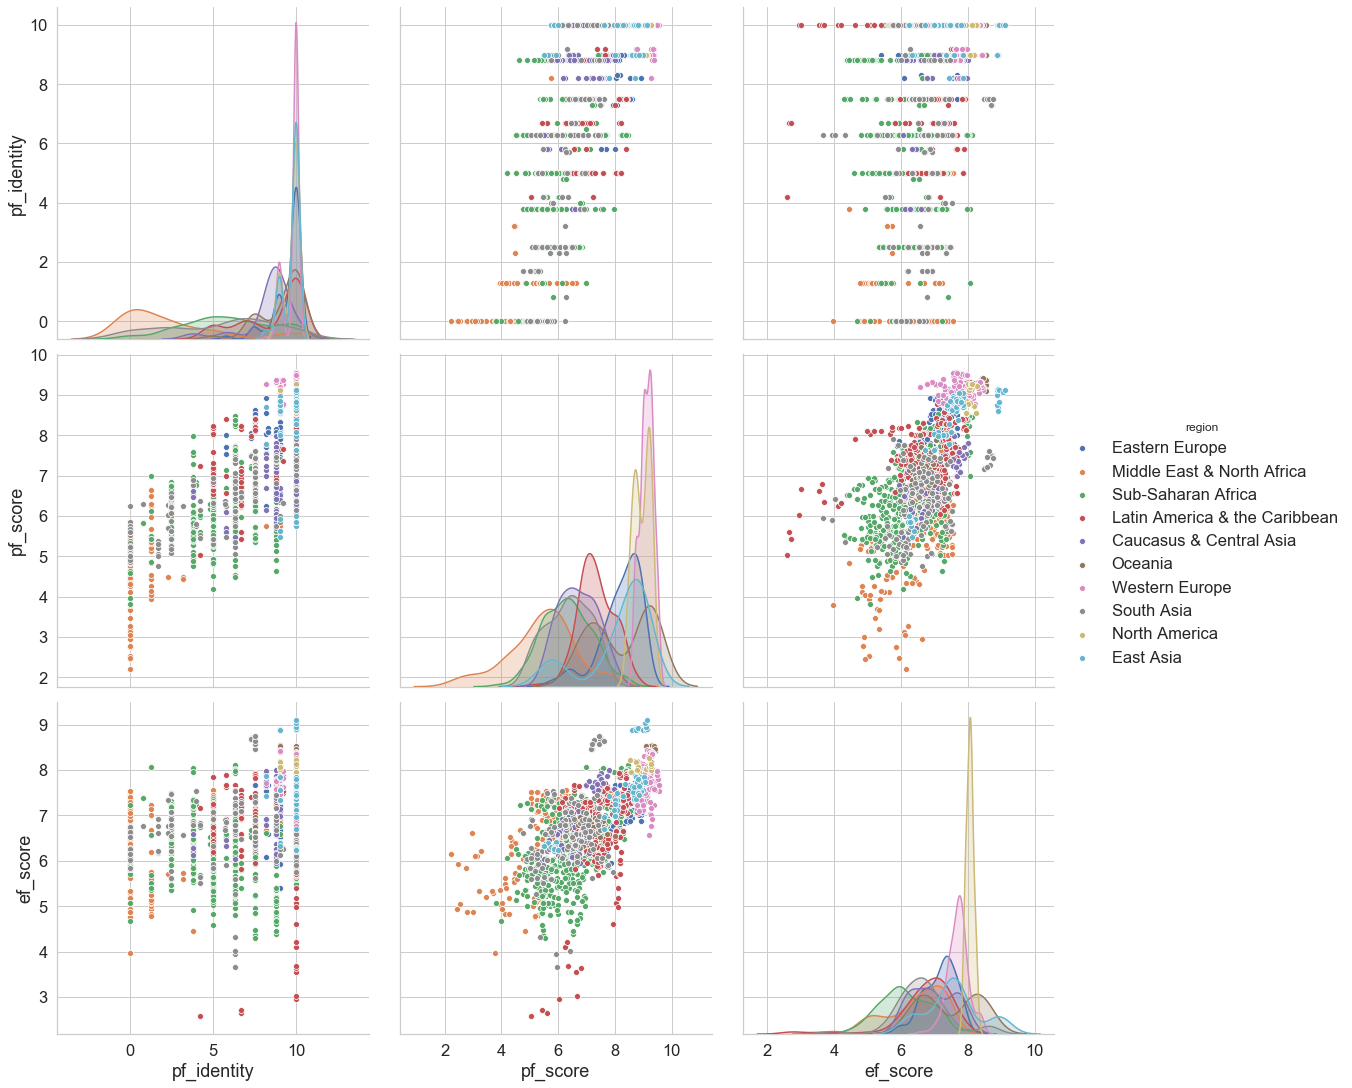

In [237]:
seaborn.pairplot(data=dataset,
                 vars=['pf_identity', 'pf_score', 'ef_score'],
                 hue='region', height=5)

#### 4.2

##### Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.

En ambos casos vemos una correlación, la correlación con pf_score es mayor dado que éste esta formado en parte por pf_identity.
En el caso de ef_score, la correlación es menor pero existe. 

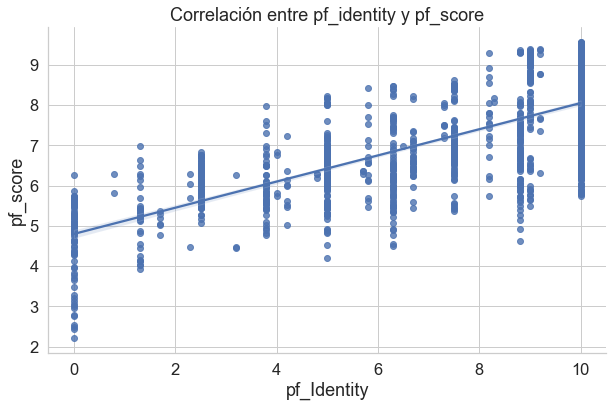

In [238]:
plt.figure(figsize=(10,6))
seaborn.regplot(data=dataset, 
                x='pf_identity',
                y='pf_score')
plt.xlabel('pf_Identity')
plt.ylabel('pf_score')
plt.title('Correlación entre pf_identity y pf_score')
seaborn.despine()

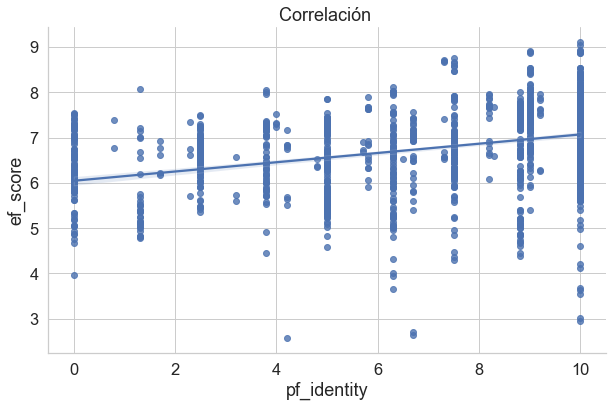

In [239]:
plt.figure(figsize=(10,6))
seaborn.regplot(data=dataset, x='pf_identity',
                y='ef_score')
plt.xlabel('pf_identity')
plt.ylabel('ef_score')
plt.title('Correlación ')
seaborn.despine()

#### 4.3 
Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores high, medium y low. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como pandas.cut o pandas.dcut. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles

Utilice pandas cut, dividiendo en 3 intervalos iguales (por defecto)

In [250]:
segment_names=['low', 'medium', 'high']
pf_identity_segment = pandas.cut(dataset.pf_identity, bins=3, labels=segment_names)
ef_score_segment = pandas.cut(dataset.ef_score, bins=3, labels=segment_names)
pf_score_segment = pandas.cut(dataset.pf_score, bins=3, labels=segment_names)

In [251]:
data_test = dataset.copy()

In [260]:
data_test['pf_identity_segment'] = pf_identity_segment

### 4.4
Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.

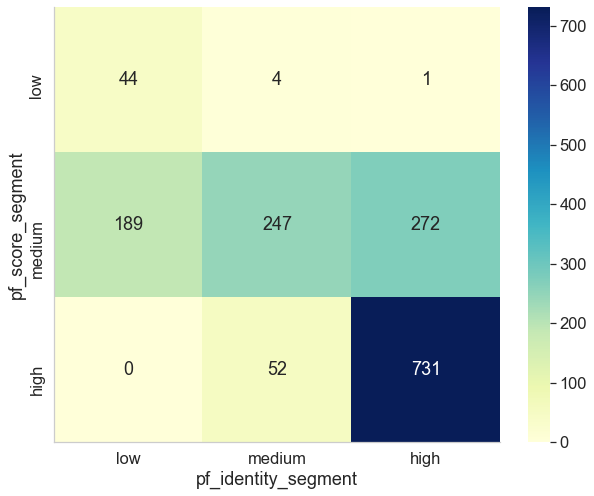

In [277]:
plt.figure(figsize=(10,8))
exp = pandas.crosstab(data_test.pf_score_segment, data_test.pf_identity_segment)
seaborn.heatmap(exp, annot=True, fmt="d", cmap='YlGnBu')
seaborn.despine()

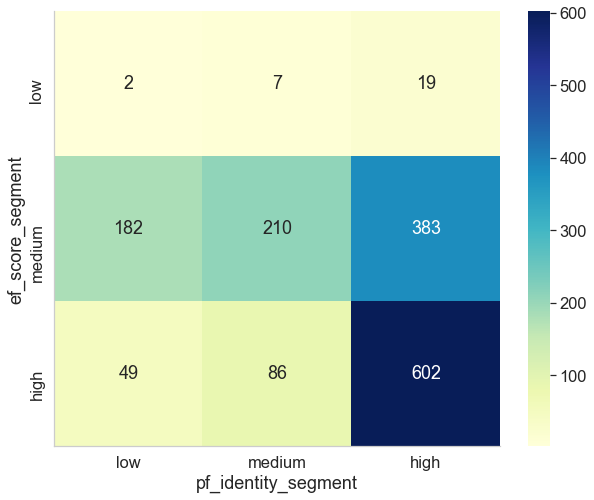

In [278]:
plt.figure(figsize=(10,8))
exp = pandas.crosstab(data_test.ef_score_segment, data_test.pf_identity_segment)
seaborn.heatmap(exp, annot=True, fmt="d", cmap='YlGnBu')
seaborn.despine()

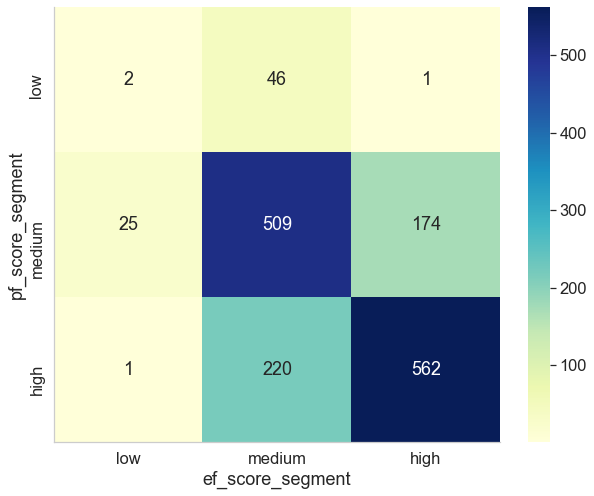

In [279]:
plt.figure(figsize=(10,8))
exp = pandas.crosstab(data_test.pf_score_segment, data_test.ef_score_segment)
seaborn.heatmap(exp, annot=True, fmt="d", cmap='YlGnBu')
seaborn.despine()

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

### KS test para PF_IDENTITY

In [440]:
# Normalizamos la distribucion
latin_america = dataset[dataset.region == 'Latin America & the Caribbean']['pf_identity'].dropna()

normalized_latin_america=(latin_america-latin_america.mean())/latin_america.std()

stats.kstest(normalized_latin_america, 'norm')

KstestResult(statistic=0.3487708981617609, pvalue=1.489356122294589e-28)

Al realizar el KS test para Latin America & the Caribbean obtenemos un p-valor superior al estadistico por lo que NO contamos con evidencia suficiente para rechazar la Hipotesis Nula (que proponia que se trataba de una distribucion Normal).

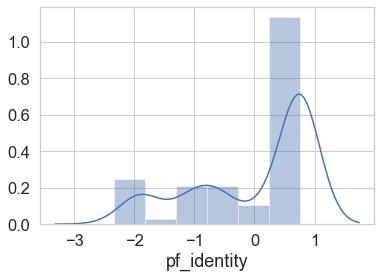

In [434]:
seaborn.distplot(normalized_latin_america)

In [437]:
# Normalizamos la distribucion
north_america = dataset[dataset.region == 'North America']['pf_identity'].dropna()

normalized_north_america=(north_america-north_america.mean())/north_america.std()

stats.kstest(normalized_north_america, 'norm')

KstestResult(statistic=0.46319111192950946, pvalue=0.00018919697809718092)

Al realizar el KS test para North America obtenemos un p-valor inferior al estadistico por lo que Rechazamos la Hipotesis Nula (que proponia que se trataba de una distribucion Normal)

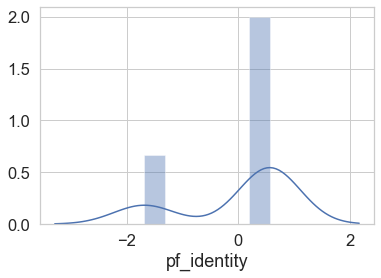

In [438]:
seaborn.distplot(normalized_north_america)

### KS test para PF_SCORE

En este caso NO podemos rechazar la Hipotesis Nula para Latin America y North America.

In [386]:
# Normalizamos la distribucion
latin_america = dataset[dataset.region == 'Latin America & the Caribbean']['pf_score'].dropna()

normalized_latin_america=(latin_america-latin_america.mean())/latin_america.std()

stats.kstest(normalized_latin_america, 'norm')

KstestResult(statistic=0.054270551553745605, pvalue=0.4221030427808178)

In [385]:
# Normalizamos la distribucion
north_america = dataset[dataset.region == 'North America']['pf_score'].dropna()

normalized_north_america=(north_america-north_america.mean())/north_america.std()

stats.kstest(normalized_north_america, 'norm')

KstestResult(statistic=0.2077427985435053, pvalue=0.3103655336455261)

### KS test para EF_SCORE

En este caso Rechazamos la Hipotesis Nula para Latin America pero para North America no contamos con evidencia suficiente para rechazar la Hipotesis Nula.

In [388]:
# Normalizamos la distribucion
latin_america = dataset[dataset.region == 'Latin America & the Caribbean']['ef_score'].dropna()

normalized_latin_america=(latin_america-latin_america.mean())/latin_america.std()

stats.kstest(normalized_latin_america, 'norm')

KstestResult(statistic=0.13653982441091805, pvalue=0.00011737833201774813)

In [390]:
# Normalizamos la distribucion
north_america = dataset[dataset.region == 'North America']['ef_score'].dropna()

normalized_north_america=(north_america-north_america.mean())/north_america.std()

stats.kstest(normalized_north_america, 'norm')

KstestResult(statistic=0.13215457740719216, pvalue=0.8759537837175628)

#### A nivel Global para la Variable PF_SCORE tampoco podemos rechazar la Hipotesis Nula. 

In [441]:
# Normalizamos la distribucion
world = dataset['pf_score'].dropna()

normalized_world=(world-world.mean())/world.std()

stats.kstest(normalized_world, 'norm')

KstestResult(statistic=0.07046101203546518, pvalue=4.297580535010432e-07)

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Nota Milagro Slack, @aquí, vamos a hacer un anuncio general: El punto 4.4 de la parte 1 en el práctico es un horror! Felicitaciones a los grupos que se dieron cuenta de que lo que está escrito no tiene ningún sentido, no sé cómo se me pasó. Veamos, region NO ES ORDINAL, y no hay forma de hacerlo ordinal. El test Tau-Kendall es para variables ordinales o rankings, así que no se aplica a region. Hay dos opciones, o hacen un test para correlación de categóricas, o usan otro par de variable que se pueda hacer ordinal usando pandas.cut y aplican Kendall. Lo que les parezca más interesante de resolver. (editado) 


Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?